In [45]:
#INSTALAR PAQUETES
#!pip install wordcloud
#!pip install imbalanced-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS #Lista predeterminada de palabras vacías en inglés
import string
import re  #Biblioteca para utilizar expresiones regulares

#from sklearn.model_selection import train_test_split 
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.naive_bayes import MultinomialNB

In [57]:
data1=pd.read_csv("./deteccion_spam/datos/enronSpamSubset.csv")
data2=pd.read_csv("./deteccion_spam/datos/lingSpam.csv")
data3=pd.read_csv("./deteccion_spam/datos/completeSpamAssassin.csv")

data1.drop(["Unnamed: 0","Unnamed: 0.1"],inplace=True,axis=1)
data2.drop("Unnamed: 0",inplace=True,axis=1)
data3.drop("Unnamed: 0",inplace=True,axis=1)

In [ ]:
data3.head()

## Preprocesamiento

In [58]:
def preprocesamiento(data):
    data.drop_duplicates() #Eliminamos los correos duplicados (parece que no había)
    data.dropna() #Eliminamos los correos con valores nulos
    data = data.dropna(subset=['Body'])
    
    #Quitamos mayúsculas
    data['Body'] = data['Body'].str.lower()
    
    #Eliminamos signos de puntuación
    data['Body'] = data['Body'].str.replace('[{}]'.format(string.punctuation), '')
        
    #Creamos una lista personalizada de palabras vacías
    stop_words_list = list(ENGLISH_STOP_WORDS)
    stop_words_list += ["subject"]
    
    #Este patron representa todos los caracteres alfanuméricos. 
    pattern = "[^a-zA-Z0-9]" 
    #Vamos a eliminar todos los elementos que no sean caracteres alfanuméricos, como signos de puntuación, etc.
    data['Body'] = data['Body'].apply(lambda x: re.sub(pattern, ' ', x)) #Sustituyo todos los caracteres que no cumplen el patrón por un " "
    
    #Eliminamos las stop_words_list del data
    data['Body'] = data['Body'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words_list]))
    
    return data

In [59]:
data1=preprocesamiento(data1)

In [60]:
data1

,Body,Label
0,stock promo mover cwtd urgent investor trading...,1
1,listed major search engines submitting website...,1
2,important information thu 30 jun 2005 importan...,1
3,utf 8 q bask life utf 8 q individual incremen ...,1
4,bidstogo places things hello privacy policy pe...,1
...,...,...
9995,monday 22 nd oct louise half hour free diary 2...,0
9996,missing bloomberg deals stephanie believe ve t...,0
9997,eops salary survey questionnaire need establis...,0
9998,q 3 comparison hi louise comparison weeks q 3 ...,0


## Desbalanceo de clases

In [3]:
#Función para visualizar la distribución de las clases (para ver si hay desbalanceo)
def distribucion(data, title):
    #Calculo la cantidad de correos electrónicos en cada clase
    class_distribution = data['Label'].value_counts()
    class_distribution = class_distribution.sort_index() #Simplemente para que la clase 0 aparezca primero
    
    # Visualizar la distribución de las clases
    plt.figure(figsize=(8, 6))
    class_distribution.plot(kind='bar', color= ['#45D2EB', '#FF5733'])
    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Cantidad de Correos Electrónicos')
    plt.xticks(rotation=0)
    plt.show()

    print(class_distribution)

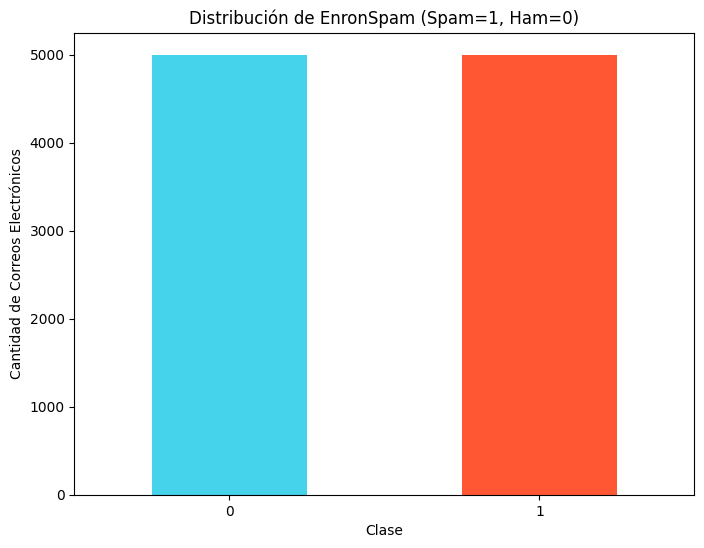

Label
0    5000
1    5000
Name: count, dtype: int64


In [4]:
distribucion(data1, "Distribución de EnronSpam (Spam=1, Ham=0)")

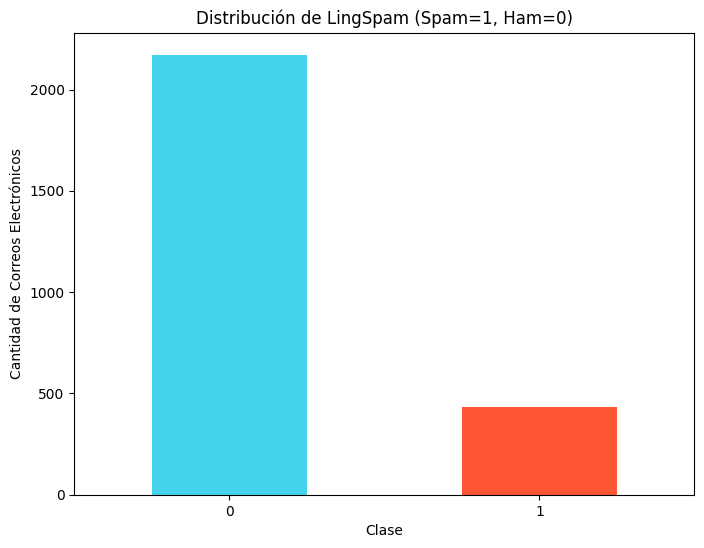

Label
0    2172
1     433
Name: count, dtype: int64


In [33]:
distribucion(data2, "Distribución de LingSpam (Spam=1, Ham=0)")

In [ ]:
distribucion(data3, "Distribución de SpamAssassin (Spam=1, Ham=0)")

Clases bastante desbalanceadas, necesitamos aplicar una técnica de balanceo

In [34]:
# Separa las características y las etiquetas
X = data2.drop('Label', axis=1)  # características
y = data2['Label']  # etiquetas

# Aplico el sobremuestreo
oversample = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Concatena las características y las etiquetas en un nuevo DataFrame
data_resampled2 = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Label'])], axis=1)

# Ahora 'data_resampled' contiene el conjunto de datos con clases balanceadas


In [35]:
X_resampled.head()

,Unnamed: 0,Body
0,0,subject: great part-time summer job ! * * * * ...
1,1,subject: auto insurance rates high ? dear nlpe...
2,2,subject: want best economical hunting vacation...
3,3,subject: email 57 million people $ 99 57 milli...
4,4,subject: n't miss ! attention ! warning ! adul...


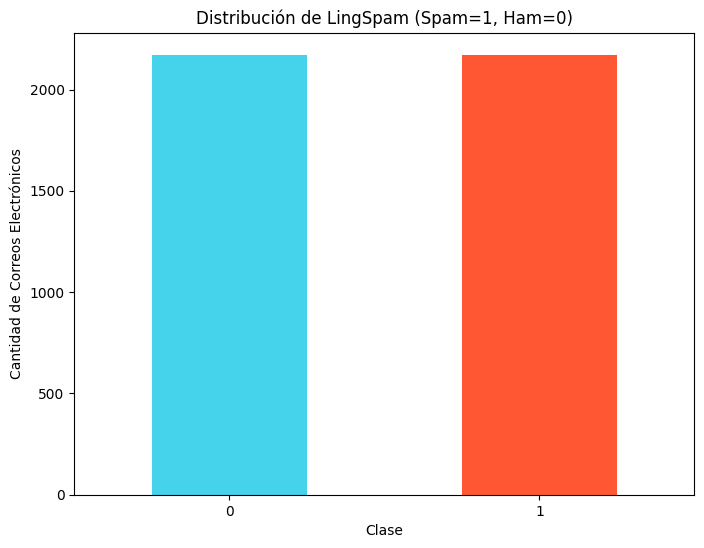

Label
0    2172
1    2172
Name: count, dtype: int64


In [19]:
distribucion(data_resampled2, "Distribución de LingSpam (Spam=1, Ham=0)")

## Longitud de los correos
Queremos estudiar si hay relación entre el número de palabras que tiene un correo y su clase.

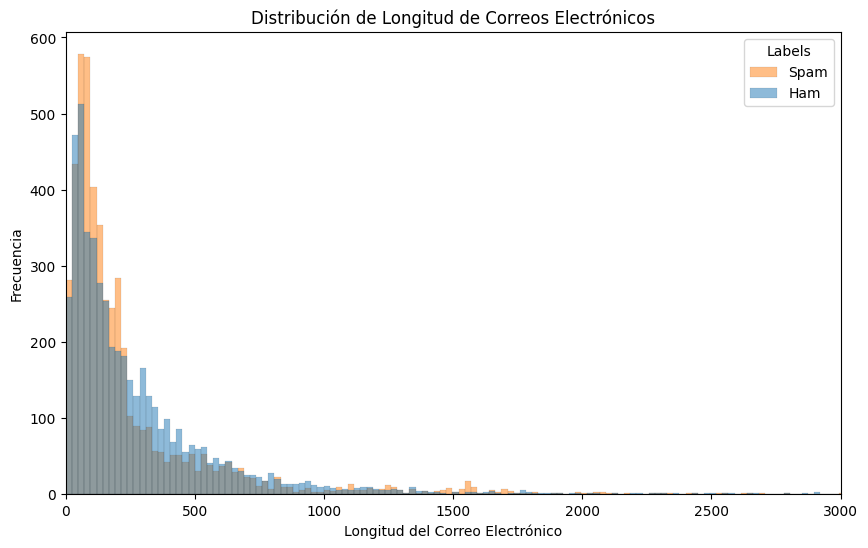

In [5]:
#Función que devuelve el número de palabras que tiene un correo
def num_words(email):
    return len(email.split())

def distribucion_longitud(data):
    #Aplico la función num_words a cada fila de la columna "Body" y guardo el resultado en una nueva columna "n_words"
    data1["n_words"] = data1["Body"].apply(num_words)
    data1.head()
    
    plt.figure(figsize=(10, 6))
    plt.title("Distribución de Longitud de Correos Electrónicos")
    sns.histplot(data=data, x="n_words", hue="Label")
    plt.xlabel('Longitud del Correo Electrónico')
    plt.ylabel('Frecuencia')
    plt.xlim(0, 3000)
    plt.legend(title="Labels", labels={"Spam":1, "Ham":0})
    plt.show()
    
distribucion_longitud(data1) #Muestro la Longitud de correos en Enron

Observamos que los correos de Spam suelen tener ligeramente menor número de palabras.

### Selección de características
Para hacer un estudio de las nuevas características (palabras), vamos a visualizar en primer lugar un Wordcloud.

stock promo mover cwtd urgent investor trading alert weekly stock pick china world trade corp ticker cwtd breaking news china world trade corp enters agreement acquire majority stake ceo clubs china limited ceo clubs tianhe guangzhou china market wire apr 7 2004 china world trade corp otc bb cwtd ob news announced today entered agreement acquired majority stake ceo clubs china limited ceo clubs hong kong corporation authorized chapter operate ceo clubs trademarks greater china region including prc hong kong taiwan china world trade corp symbol cwtd price 4 80 shares 16 million market capitalization 19 million significant revenue growth


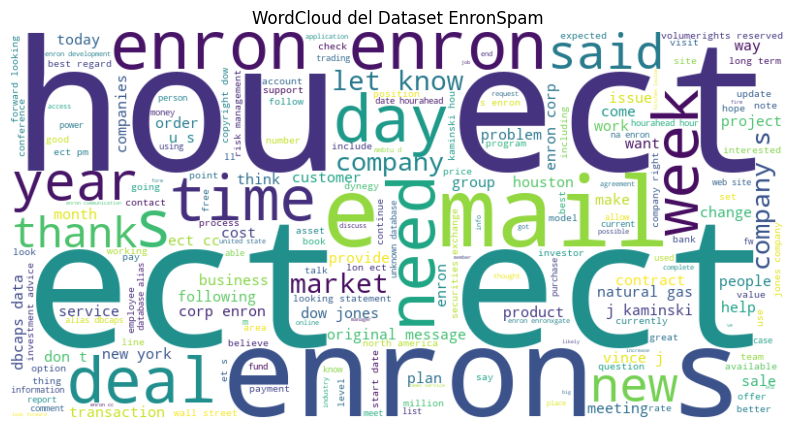

legislative report 07 20 2001 independent energy producer s lobbying firm sue mara enron corp tel 415 782 7802 fax 415 782 7854 forwarded susan j mara na enron 07 22 2001 11 16 pm martinez michael 07 20 2001 08 14 pm alex sugaoka e mail woods e mail bob ellery e mail bob escalante e mail bob gates e mail carolyn baker e mail charles linthicum e mail cody carter e mail curt hatton e mail curtis kebler e mail david parquet dean gosselin e mail douglas kerner e mail duane nelsen e mail ed tomeo e mail


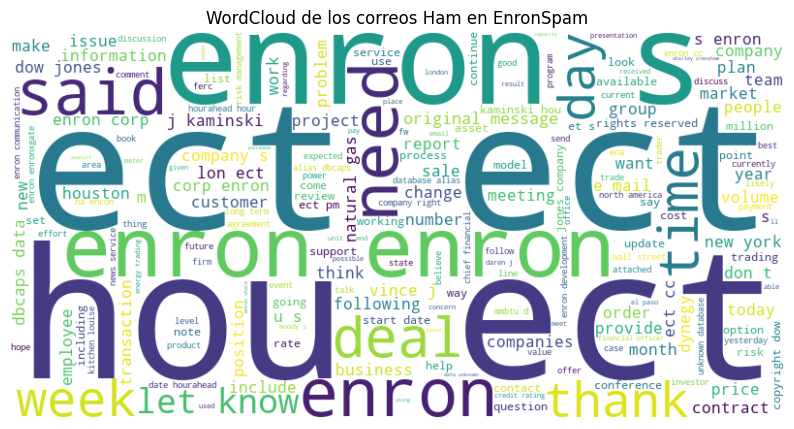

stock promo mover cwtd urgent investor trading alert weekly stock pick china world trade corp ticker cwtd breaking news china world trade corp enters agreement acquire majority stake ceo clubs china limited ceo clubs tianhe guangzhou china market wire apr 7 2004 china world trade corp otc bb cwtd ob news announced today entered agreement acquired majority stake ceo clubs china limited ceo clubs hong kong corporation authorized chapter operate ceo clubs trademarks greater china region including prc hong kong taiwan china world trade corp symbol cwtd price 4 80 shares 16 million market capitalization 19 million significant revenue growth


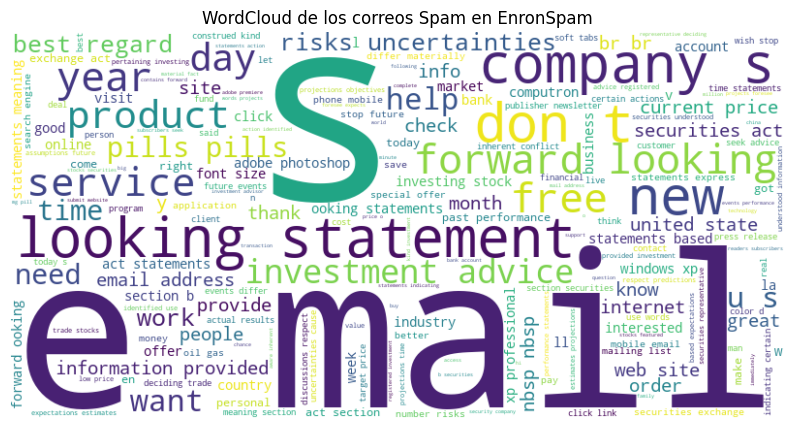

In [63]:
def Wordcloud(data, titulo):
    #Concateno todo el texto de los correos electrónicos en una sola cadena
    texto = " ".join(data['Body'])
    palabras_mostrar = " ".join(texto.split()[:100])
    print(palabras_mostrar)
    # Crear un objeto WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)

    # Mostrar el WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(titulo)
    plt.axis('off')  # Ocultar los ejes
    plt.show()


Wordcloud(data1, "WordCloud del Dataset EnronSpam")
Wordcloud(data1[data1["Label"]==0], "WordCloud de los correos Ham en EnronSpam")
Wordcloud(data1[data1["Label"]==1], "WordCloud de los correos Spam en EnronSpam")